In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

/Users/Sylvain/.pyenv/versions/3.6.4/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Link towards reporting gsheet document:
https://docs.google.com/spreadsheets/d/1o0O9HGCUABQWF1C6uHw65veY9Axd3pATWwdG2WSpdf8/edit?usp=sharing

In [2]:
# Parameters corresponding to gsheet file
CLASS_NBR = 6
MODE = "cached" # "direct" or "cached"
KERNEL = "linear" # "linear" or "rbf"
LR = 0.1
BATCH_SIZE = 64
C = 3
EPOCHS = 1000

In [3]:
# Local parameters
N_TRAIN = 850
CNN_OUTPUT_DIR = os.path.join("..", "tmp", "cnn_output", "VGG16")
TARGET_W = 224
MODEL_DIR_DIRECT = None#"../tmp/estimator_svdd_direct"
MODEL_DIR_CACHED = None#"../tmp/estimator_svdd_cached"

# Input data

In [4]:
from data_utils import train_cnn_input_fn, test_cnn_input_fn, train_input_fn, test_input_fn

# Sanity check
train_cnn_input_fn(
    CLASS_NBR,
    CNN_OUTPUT_DIR
), test_cnn_input_fn(
    CLASS_NBR,
    CNN_OUTPUT_DIR
), train_input_fn(
    CLASS_NBR,
    TARGET_W
), test_input_fn(
    CLASS_NBR,
    TARGET_W
)

(<MapDataset shapes: (25088,), types: tf.float32>,
 <MapDataset shapes: ((25088,), <unknown>), types: (tf.float32, tf.int32)>,
 <MapDataset shapes: (224, 224, 3), types: tf.float32>,
 <MapDataset shapes: ((224, 224, 3), <unknown>), types: (tf.float32, tf.int32)>)

# Training

In [5]:
from estimator_svdd import SVDDClassifier as SVDDClassifier

if MODE == "cached":
    input_fn_train = lambda: train_cnn_input_fn(CLASS_NBR, CNN_OUTPUT_DIR).shuffle(1000).repeat().batch(BATCH_SIZE)
    input_fn_test = lambda: test_cnn_input_fn(CLASS_NBR, CNN_OUTPUT_DIR).batch(BATCH_SIZE)
    train_hooks = []
    test_hooks = train_hooks
    MODEL_DIR = MODEL_DIR_CACHED
elif MODE == "direct":
    from vgg_network import VGG_Network
    from data_utils import _LoadPreTrainedWeights
    from data_utils import run_dataset_through_network
    
    net = VGG_Network(include_FC_head=False)
    
    def get_train_dataset(net, reuse=False):
        dataset = train_input_fn(CLASS_NBR, TARGET_W).batch(BATCH_SIZE)
        dataset = run_dataset_through_network(dataset, net, reuse=reuse)
        return dataset.repeat()
    
    def get_test_dataset(net, reuse=False):
        dataset = test_input_fn(CLASS_NBR, TARGET_W).batch(BATCH_SIZE)
        dataset = dataset.map(lambda img, label: img)
        dataset = run_dataset_through_network(dataset, net, reuse=reuse)
        return dataset
    
    input_fn_train = lambda: get_train_dataset(net, reuse=False)
    input_fn_test = lambda: get_test_dataset(net, reuse=False)
    train_hooks = [_LoadPreTrainedWeights(net)]
    test_hooks = train_hooks
    MODEL_DIR = MODEL_DIR_DIRECT
else:
    raise Exception("MODE unknown")
    
classifier = SVDDClassifier(
    c=C,
    kernel=KERNEL,
    learning_rate=LR,
    model_dir=MODEL_DIR,
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/_f/7t_whmpx0zn2ln3npht19g8h0000gn/T/tmp7ce5u856', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1155a32b0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [6]:
classifier.train(
    input_fn=input_fn_train,
    steps=EPOCHS * N_TRAIN / BATCH_SIZE,
    hooks=train_hooks
)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/_f/7t_whmpx0zn2ln3npht19g8h0000gn/T/tmp7ce5u856/model.ckpt.
INFO:tensorflow:loss = 2574568.2, step = 1
INFO:tensorflow:global_step/sec: 10.9435
INFO:tensorflow:loss = 533241.94, step = 101 (9.139 sec)
INFO:tensorflow:global_step/sec: 10.6169
INFO:tensorflow:loss = 406235.9, step = 201 (9.420 sec)
INFO:tensorflow:global_step/sec: 11.7292
INFO:tensorflow:loss = 355632.1, step = 301 (8.525 sec)
INFO:tensorflow:global_step/sec: 10.2821
INFO:tensorflow:loss = 338309.47, step = 401 (9.726 sec)
INFO:tensorflow:global_step/sec: 11.4281
INFO:tensorflow:loss = 329084.12, step = 501 (8.750 sec)
INFO:tensorflow:global_step/sec: 10.3376
INFO:tensorflow:loss = 317265.3, step = 601 (9.673 sec)
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 11.1709
INFO:tensorflow:loss = 121844.11, step = 7901 (8.952 sec)
INFO:tensorflow:global_step/sec: 10.019
INFO:tensorflow:loss = 126360.91, step = 8001 (9.981 sec)
INFO:tensorflow:global_step/sec: 10.5646
INFO:tensorflow:loss = 127649.984, step = 8101 (9.466 sec)
INFO:tensorflow:global_step/sec: 8.13424
INFO:tensorflow:loss = 128064.36, step = 8201 (12.293 sec)
INFO:tensorflow:global_step/sec: 9.66185
INFO:tensorflow:loss = 124282.05, step = 8301 (10.350 sec)
INFO:tensorflow:global_step/sec: 11.0283
INFO:tensorflow:loss = 125563.29, step = 8401 (9.068 sec)
INFO:tensorflow:global_step/sec: 10.607
INFO:tensorflow:loss = 129936.22, step = 8501 (9.427 sec)
INFO:tensorflow:global_step/sec: 11.7071
INFO:tensorflow:loss = 128752.875, step = 8601 (8.542 sec)
INFO:tensorflow:global_step/sec: 10.5012
INFO:tensorflow:loss = 126853.164, step = 8701 (9.523 sec)
INFO:tensorflow:global_step/sec: 11.5904
INFO:tensorflow:loss = 128797.08, step = 8801 (8.628 sec)
INFO:te

# Predicting

## Test set

In [14]:
predictions = classifier.predict(
    input_fn=input_fn_test,
    hooks=test_hooks
)

predictions_list = list(predictions)
test_predicted_scores = np.asarray(list(map(lambda p: p["predicted_scores"], predictions_list))).astype(np.int32)
test_predicted_classes = np.asarray(list(map(lambda p: p["predicted_classes"], predictions_list))).astype(np.int32)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/_f/7t_whmpx0zn2ln3npht19g8h0000gn/T/tmp7ce5u856/model.ckpt-13282
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


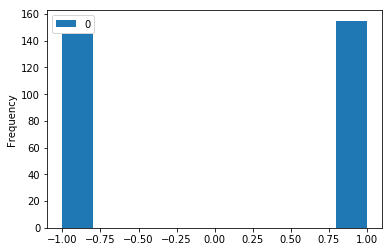

In [15]:
df = pd.DataFrame(test_predicted_classes)
df.plot.hist()

## Train set

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/_f/7t_whmpx0zn2ln3npht19g8h0000gn/T/tmp7ce5u856/model.ckpt-13282
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


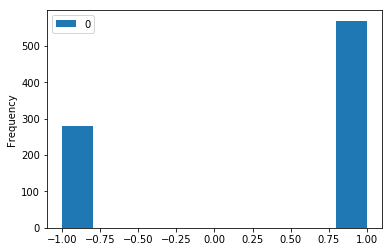

In [16]:
from data_utils import _cnn_input_fn
predictions = classifier.predict(
    input_fn=lambda: train_cnn_input_fn(CLASS_NBR, CNN_OUTPUT_DIR).batch(BATCH_SIZE)
)

predictions_list = list(predictions)
train_predicted_scores = np.asarray(list(map(lambda p: p["predicted_scores"], predictions_list))).astype(np.int32)
train_predicted_classes = np.asarray(list(map(lambda p: p["predicted_classes"], predictions_list))).astype(np.int32)

df = pd.DataFrame(train_predicted_classes)
df.plot.hist()

# Validation and metrics

## On test set

In [17]:
# Test set
y_test = []
input_fn = test_cnn_input_fn(CLASS_NBR, CNN_OUTPUT_DIR).batch(1)
input_fn = input_fn.make_one_shot_iterator().get_next()
sess = tf.Session()
while True:
    try:
        data = sess.run(input_fn)
        y_test.append(data[1][0])
    except tf.errors.OutOfRangeError:
        break
y_test = np.asarray(y_test)
y_test.shape

(300,)

Confusion matrix, without normalization
[[ 95  55]
 [ 50 100]]


Accuracy     0.650000
Precision    0.645161
Recall       0.666667
f1-score     0.655738
dtype: float64

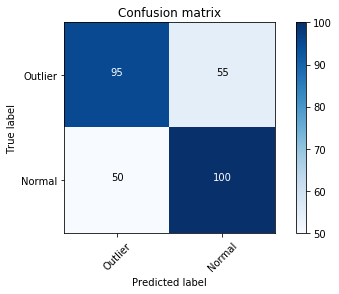

In [18]:
from validation import evaluation_summary
evaluation_summary(y_test, test_predicted_classes, plot_cm=True)

## On train set

In [19]:
# Train set
y_train = np.ones(N_TRAIN)
y_train.shape

(850,)

Confusion matrix, without normalization
[[  0   0]
 [281 569]]


Accuracy     0.669412
Precision    1.000000
Recall       0.669412
f1-score     0.801973
dtype: float64

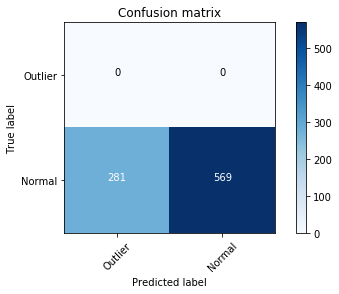

In [20]:
from validation import evaluation_summary
evaluation_summary(y_train, train_predicted_classes, plot_cm=True)